In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# !rm -rf mmsegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
# !pip install -e .

/home/ruili/proj3/nahiri-p3/mmsegmentation


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

import os.path as osp
import numpy as np
from PIL import Image

import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

1.6.0 True
0.12.0


In [4]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r101-d8_512x512_40k_voc12aug/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth -P checkpoints

--2021-04-23 14:25:05--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r101-d8_512x512_40k_voc12aug/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272439375 (260M) [application/octet-stream]
Saving to: ‘checkpoints/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth’

pspnet_r101-d8_512x 100%[===================>] 259.82M  8.69MB/s    in 31s     

2021-04-23 14:25:36 (8.41 MB/s) - ‘checkpoints/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth’ saved [272439375/272439375]



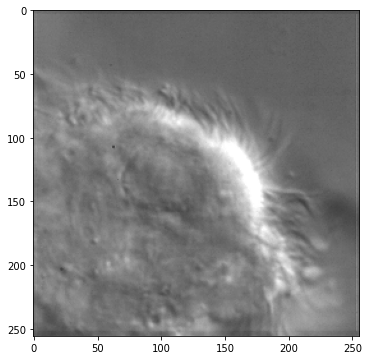

In [4]:
img = mmcv.imread('../data/my_dataset/img_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [5]:
# convert dataset annotation to semantic segmentation map
data_root = '../data/my_dataset'
img_dir = 'img_dir/train'
ann_dir = 'ann_dir/train'
# define class and plaette for better visualization
classes = ('background', 'cell', 'cilia')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125]]

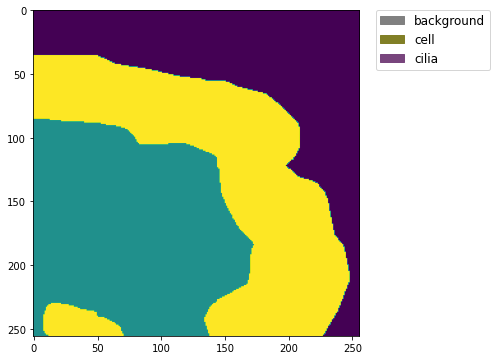

In [6]:
img = Image.open('../data/my_dataset/ann_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [7]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

In [8]:
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [9]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class CiliaDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [10]:
from mmcv import Config
cfg = Config.fromfile('./configs/pspnet/pspnet_r101-d8_512x512_40k_voc12aug.py')

In [11]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'CiliaDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu= 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = './checkpoints/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 800
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input

In [12]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/ruili/anaconda3/envs/open-mmlab/lib/python3.8/site-packages/mmcv/utils/misc.py:303: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  warnings.warn(
2021-04-23 14:25:57,795 - mmseg - INFO - Loaded 16880 images
2021-04-23 14:25:58,327 - mmseg - INFO - Use load_from_openmmlab loader
2021-04-23 14:25:58,475 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-04-23 14:26:00,490 - mmseg - INFO - Loaded 4220 images
2021-04-23 14:26:00,490 - mmseg - INFO - load checkpoint from ./checkpoints/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth
2021-04-23 14:26:00,491 - mmseg - INFO - Use load_from_local loader
2021-04-23 14:26:00,659 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model 

[>>>>>>>>>>>>>>>>] 4220/4220, 11.9 task/s, elapsed: 355s, ETA:     0s 0s, ETA:

2021-04-23 14:33:47,327 - mmseg - INFO - per class results:
2021-04-23 14:33:47,328 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 71.79 | 83.19 |
| cell       | 56.85 | 80.04 |
| cilia      | 5.3   | 5.86  |
+------------+-------+-------+
2021-04-23 14:33:47,328 - mmseg - INFO - Summary:
2021-04-23 14:33:47,329 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 44.65 | 56.36 | 76.25 |
+--------+-------+-------+-------+
2021-04-23 14:33:47,333 - mmseg - INFO - Iter(val) [200]	mIoU: 0.4465, mAcc: 0.5636, aAcc: 0.7625, IoU.background: 0.7179, IoU.cell: 0.5685, IoU.cilia: 0.0530, Acc.background: 0.8319, Acc.cell: 0.8004, Acc.cilia: 0.0586
2021-04-23 14:33:52,098 - mmseg - INFO - Iter [210/800]	lr: 7.638e-03, eta: 0:21:48, time: 37.938, data_time: 37.465, memory: 2206, decode.loss_seg: 0.5374, decode.acc_seg: 61.6740, aux.loss_seg

[>>>>>>>>>>>>>>>>] 4220/4220, 11.8 task/s, elapsed: 356s, ETA:     0s 0s, ETA:

2021-04-23 14:41:38,088 - mmseg - INFO - per class results:
2021-04-23 14:41:38,093 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 69.06 | 72.72 |
| cell       | 58.02 | 90.34 |
| cilia      | 14.31 | 21.29 |
+------------+-------+-------+
2021-04-23 14:41:38,094 - mmseg - INFO - Summary:
2021-04-23 14:41:38,094 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 47.13 | 61.45 | 74.65 |
+--------+-------+-------+-------+
2021-04-23 14:41:38,102 - mmseg - INFO - Iter(val) [400]	mIoU: 0.4713, mAcc: 0.6145, aAcc: 0.7465, IoU.background: 0.6906, IoU.cell: 0.5802, IoU.cilia: 0.1431, Acc.background: 0.7272, Acc.cell: 0.9034, Acc.cilia: 0.2129
2021-04-23 14:41:42,902 - mmseg - INFO - Iter [410/800]	lr: 5.298e-03, eta: 0:14:45, time: 38.044, data_time: 37.570, memory: 2206, decode.loss_seg: 0.4788, decode.acc_seg: 71.2779, aux.loss_seg

[>>>>>>>>>>>>>>>>] 4220/4220, 11.8 task/s, elapsed: 358s, ETA:     0s 0s, ETA:

2021-04-23 14:49:31,433 - mmseg - INFO - per class results:
2021-04-23 14:49:31,436 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 77.51 | 82.08 |
| cell       | 65.23 | 90.33 |
| cilia      | 18.2  | 25.86 |
+------------+-------+-------+
2021-04-23 14:49:31,436 - mmseg - INFO - Summary:
2021-04-23 14:49:31,437 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 53.65 | 66.09 | 80.53 |
+--------+-------+-------+-------+
2021-04-23 14:49:31,441 - mmseg - INFO - Iter(val) [600]	mIoU: 0.5365, mAcc: 0.6609, aAcc: 0.8053, IoU.background: 0.7751, IoU.cell: 0.6523, IoU.cilia: 0.1820, Acc.background: 0.8208, Acc.cell: 0.9033, Acc.cilia: 0.2586
2021-04-23 14:49:36,259 - mmseg - INFO - Iter [610/800]	lr: 2.828e-03, eta: 0:07:15, time: 38.294, data_time: 37.816, memory: 2206, decode.loss_seg: 0.4027, decode.acc_seg: 76.1739, aux.loss_seg

[>>>>>>>>>>>>>>>>] 4220/4220, 11.7 task/s, elapsed: 359s, ETA:     0s 0s, ETA:

2021-04-23 14:57:26,133 - mmseg - INFO - per class results:
2021-04-23 14:57:26,136 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 78.43 | 82.36 |
| cell       | 66.45 | 90.65 |
| cilia      | 21.83 | 32.3  |
+------------+-------+-------+
2021-04-23 14:57:26,136 - mmseg - INFO - Summary:
2021-04-23 14:57:26,137 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 55.57 | 68.44 | 81.29 |
+--------+-------+-------+-------+
2021-04-23 14:57:26,142 - mmseg - INFO - Iter(val) [800]	mIoU: 0.5557, mAcc: 0.6844, aAcc: 0.8129, IoU.background: 0.7843, IoU.cell: 0.6645, IoU.cilia: 0.2183, Acc.background: 0.8236, Acc.cell: 0.9065, Acc.cilia: 0.3230


/home/ruili/proj3/nahiri-p3/mmsegmentation/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

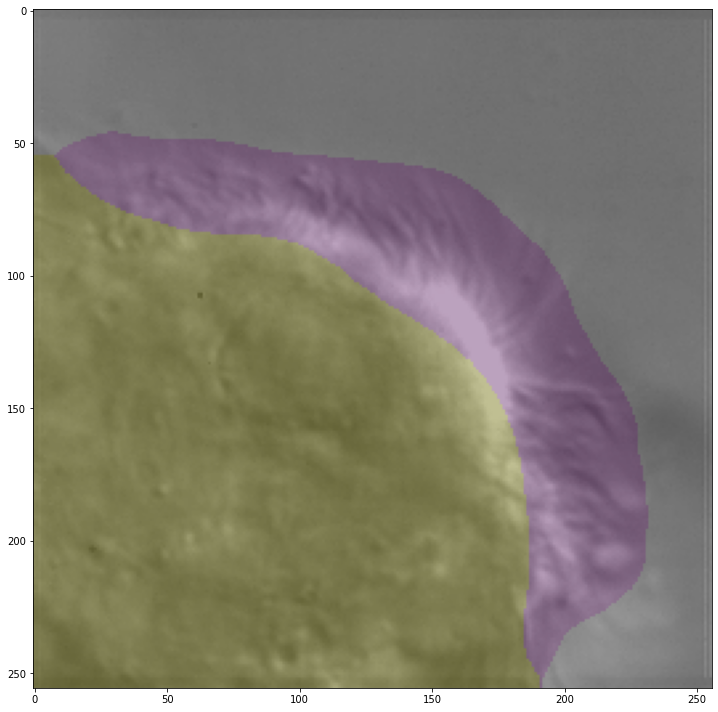

In [13]:
img = mmcv.imread('../data/my_dataset/img_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

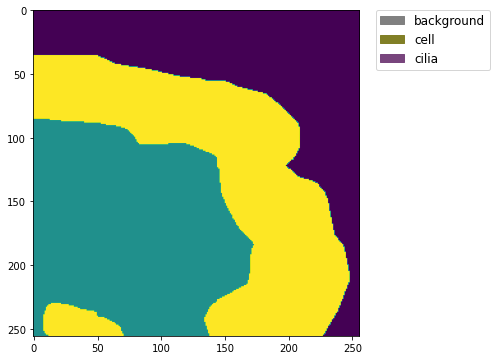

In [14]:
img = Image.open('../data/my_dataset/ann_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [16]:
import os
rootdir = '/home/ruili/proj3/nahiri-p3/data/my_dataset/img_dir/test'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if str(file).split("_frame")[1]=="0000.png":
#             print(str(file).split("_frame")[0])
            img = mmcv.imread(os.path.join(subdir, file))
            result = inference_segmentor(model, img)
            im = Image.fromarray(result[0].astype(np.uint8))
            im.save("/home/ruili/proj3/nahiri-p3/predictions/"+str(str(file).split("_frame")[0])+".png")
#             print(result[0].shape)
            
#         print(str(file).split("_frame")[1])
#         print(str(subdir).split("/")[-1])
#         print(img)
#         new_name = str(subdir).split("/")[-1] +"_"+ file
#         shutil.copy(os.path.join(subdir, file), "./data/my_dataset/img_dir/test/"+new_name)